<a href="https://colab.research.google.com/github/vsevolodi/Machine-Learning-HW/blob/main/potseluev_hw_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import logging
import os
import shutil
from tqdm import tqdm

import numpy as np
from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'hse_nlp_2021')
if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

INFO:__main__:Инициализировали логгер
INFO:__main__:Подключили диск
INFO:__main__:Содержимое директории /content/drive/MyDrive/hse_nlp_2021: ['winemag-data_first150k.csv', 'boosting_toy_dataset.csv', 'client_segmentation.csv', 'non_linear.csv', 'final_dataset.zip', 'insurance.csv', 'gray_goose.jpg', 'eigen.pkl', 'nyt-ingredients-snapshot-2015.csv', 'clustering.pkl', 'politic_meme.jpg', 'ocr_dataset.zip', 'corpora', 'torch_models', 'nltk_data_old', 'recsys_data', 'logs', 'memes', 'nltk_data', 'my_little_recsys', 'optimal_push_time', 'sklearn_data', 'test_task_data']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

raw_data_file = os.path.join(root_data_dir, 'winemag-data_first150k.csv')

df_source = pd.read_csv(
    raw_data_file, sep=',',
)

df_source.head()


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [4]:
#for test runs and time economy
#df_source = df_source[:500]

In [5]:
df_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


Here I use Doc2Vec to assign vectors to descriptions

In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
data = df_source
data["description"] = data.description.apply(lambda x: x.lower().split())
data["description"]

0         [this, tremendous, 100%, varietal, wine, hails...
1         [ripe, aromas, of, fig,, blackberry, and, cass...
2         [mac, watson, honors, the, memory, of, a, wine...
3         [this, spent, 20, months, in, 30%, new, french...
4         [this, is, the, top, wine, from, la, bégude,, ...
                                ...                        
150925    [many, people, feel, fiano, represents, southe...
150926    [offers, an, intriguing, nose, with, ginger,, ...
150927    [this, classic, example, comes, from, a, cru, ...
150928    [a, perfect, salmon, shade,, with, scents, of,...
150929    [more, pinot, grigios, should, taste, like, th...
Name: description, Length: 150930, dtype: object

In [7]:
texts = list(data.description.values)
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
documents[10:12]

[TaggedDocument(words=['elegance,', 'complexity', 'and', 'structure', 'come', 'together', 'in', 'this', 'drop-dead', 'gorgeous', 'winethat', 'ranks', 'among', "italy's", 'greatest', 'whites.', 'it', 'opens', 'with', 'sublime', 'yellow', 'spring', 'flower,', 'aromatic', 'herb', 'and', 'orchard', 'fruit', 'scents.', 'the', 'creamy,', 'delicious', 'palate', 'seamlessly', 'combines', 'juicy', 'white', 'peach,', 'ripe', 'pear', 'and', 'citrus', 'flavors', 'while', 'white', 'almond', 'and', 'savory', 'mineral', 'notes', 'grace', 'the', 'lingering', 'finish.'], tags=[10]),
 TaggedDocument(words=['from', '18-year-old', 'vines,', 'this', 'supple', 'well-balanced', 'effort', 'blends', 'flavors', 'of', 'mocha,', 'cherry,', 'vanilla', 'and', 'breakfast', 'tea.', 'superbly', 'integrated', 'and', 'delicious', 'even', 'at', 'this', 'early', 'stage,', 'this', 'wine', 'seems', 'destined', 'for', 'a', 'long', 'and', 'savory', 'cellar', 'life.', 'drink', 'now', 'through', '2028.'], tags=[11])]

In [8]:
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=10)

INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #10000, processed 402207 words (2607739 words/s), 17856 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #20000, processed 804303 words (2418253 words/s), 28131 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #30000, processed 1201282 words (2388365 words/s), 34469 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #40000, processed 1590577 words (2154594 words/s), 38842 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #50000, processed 1978399 words (2269149 words/s), 43341 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #60000, processed 2382398 words (2253298 words/s), 47671 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #70000, processed 2796774 words (2123472 

In [9]:
model.save("D2V.model")
vectors = []
for x in documents:
    vec = list(model[x.tags][0])
    vectors.append(vec)
    
split_df = pd.DataFrame(vectors,
                        columns=['v1', 'v2', 'v3','v4',"v5"])

split_df

INFO:gensim.utils:Doc2Vec lifecycle event {'fname_or_handle': 'D2V.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-05-02T15:45:24.927505', 'gensim': '4.3.1', 'python': '3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]', 'platform': 'Linux-5.10.147+-x86_64-with-glibc2.31', 'event': 'saving'}
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved D2V.model


,v1,v2,v3,v4,v5
0,-0.440964,1.461129,2.680638,3.964068,-0.474201
1,-1.289654,-0.315715,2.801712,0.178435,0.567614
2,-2.074534,1.567887,1.951514,0.969400,0.680591
3,1.043519,0.870509,0.971636,1.164158,-1.792254
4,-1.102477,1.890195,1.752979,2.500378,0.055289
...,...,...,...,...,...
150925,0.225489,0.255020,0.091634,-0.246791,-0.363258
150926,0.119004,0.194472,0.448898,-0.148070,-0.080707
150927,0.182077,0.383304,0.043032,-0.413999,-0.243680
150928,0.188177,0.314050,0.112689,0.052918,-0.170548


In [10]:
data_1 = df_source.join(split_df, how = 'left')
data_1.shape

(150930, 16)

In [11]:
data_1

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,v1,v2,v3,v4,v5
0,0,US,"[this, tremendous, 100%, varietal, wine, hails...",Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,-0.440964,1.461129,2.680638,3.964068,-0.474201
1,1,Spain,"[ripe, aromas, of, fig,, blackberry, and, cass...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,-1.289654,-0.315715,2.801712,0.178435,0.567614
2,2,US,"[mac, watson, honors, the, memory, of, a, wine...",Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,-2.074534,1.567887,1.951514,0.969400,0.680591
3,3,US,"[this, spent, 20, months, in, 30%, new, french...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1.043519,0.870509,0.971636,1.164158,-1.792254
4,4,France,"[this, is, the, top, wine, from, la, bégude,, ...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,-1.102477,1.890195,1.752979,2.500378,0.055289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150925,150925,Italy,"[many, people, feel, fiano, represents, southe...",NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio,0.225489,0.255020,0.091634,-0.246791,-0.363258
150926,150926,France,"[offers, an, intriguing, nose, with, ginger,, ...",Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain,0.119004,0.194472,0.448898,-0.148070,-0.080707
150927,150927,Italy,"[this, classic, example, comes, from, a, cru, ...",Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora,0.182077,0.383304,0.043032,-0.413999,-0.243680
150928,150928,France,"[a, perfect, salmon, shade,, with, scents, of,...",Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset,0.188177,0.314050,0.112689,0.052918,-0.170548


In [12]:
data_train = data_1[["price", "points", "v1","v2","v3","v4","v5"]]
data_train

,price,points,v1,v2,v3,v4,v5
0,235.0,96,-0.440964,1.461129,2.680638,3.964068,-0.474201
1,110.0,96,-1.289654,-0.315715,2.801712,0.178435,0.567614
2,90.0,96,-2.074534,1.567887,1.951514,0.969400,0.680591
3,65.0,96,1.043519,0.870509,0.971636,1.164158,-1.792254
4,66.0,95,-1.102477,1.890195,1.752979,2.500378,0.055289
...,...,...,...,...,...,...,...
150925,20.0,91,0.225489,0.255020,0.091634,-0.246791,-0.363258
150926,27.0,91,0.119004,0.194472,0.448898,-0.148070,-0.080707
150927,20.0,91,0.182077,0.383304,0.043032,-0.413999,-0.243680
150928,52.0,90,0.188177,0.314050,0.112689,0.052918,-0.170548


In [13]:
data_train.isna().any()

price      True
points    False
v1        False
v2        False
v3        False
v4        False
v5        False
dtype: bool

In [14]:
#I suppose we can drop non-existant values for consistency of data
data_train = data_train.dropna()

In [15]:
#to normalize the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_scaled = data_train.copy()
data_scaled[data_scaled.columns]=sc.fit_transform(data_scaled)
data_scaled.head(3)

,price,points,v1,v2,v3,v4,v5
0,5.557686,2.549015,-1.031363,2.518864,4.772887,6.487111,-0.756280
1,2.116284,2.549015,-2.600793,-1.265370,5.015018,0.603402,1.261309
2,1.565660,2.549015,-4.052222,2.746234,3.314745,1.832735,1.480101


In [16]:
from sklearn.decomposition import PCA
pca_2 = PCA(2) # задали количество компонент

pca_2_result = pca_2.fit_transform(data_scaled) 

pca_2 = pca_2_result

pca_2_result.shape

(137235, 2)

I want to look at this terrible cloud

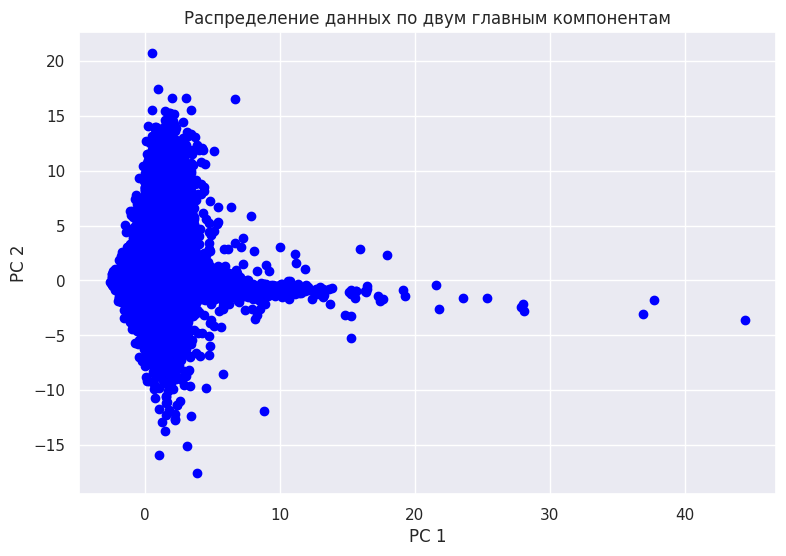

In [17]:
sns.set(rc={'figure.figsize':(9,6)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue') # 0 и 1 - индексы колонок
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

Check K-means as was done in the lecture (literally same code.. but I'm not a computational linguist to be overly extravagant).

And do inertia at the same time (why not)

In [18]:
import sklearn.cluster as cluster
inertia = []
for i in tqdm(range(2,20)):
    
    kmeans = cluster.KMeans(
               n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17
    ) 
    
    
    kmeans.fit(pca_2_result) 
    inertia.append(kmeans.inertia_)
    print(kmeans.inertia_)

  6%|▌         | 1/18 [00:01<00:33,  1.97s/it]

272124.1327001908


 11%|█         | 2/18 [00:04<00:33,  2.06s/it]

171429.8552377508


 17%|█▋        | 3/18 [00:06<00:36,  2.41s/it]

137652.38108782913


 22%|██▏       | 4/18 [00:12<00:52,  3.78s/it]

115980.60278158396


 28%|██▊       | 5/18 [00:16<00:47,  3.66s/it]

95307.20235303201


 33%|███▎      | 6/18 [00:20<00:45,  3.78s/it]

80211.53865636014


 39%|███▉      | 7/18 [00:27<00:53,  4.88s/it]

69327.17091123902


 44%|████▍     | 8/18 [00:31<00:46,  4.61s/it]

62765.25766383906


 50%|█████     | 9/18 [00:37<00:44,  4.98s/it]

57445.40452604357


 56%|█████▌    | 10/18 [00:43<00:43,  5.45s/it]

52342.35811287386


 61%|██████    | 11/18 [00:49<00:39,  5.65s/it]

47714.17807219459


 67%|██████▋   | 12/18 [00:58<00:40,  6.71s/it]

43884.783721402324


 72%|███████▏  | 13/18 [01:08<00:37,  7.52s/it]

40827.23256963367


 78%|███████▊  | 14/18 [01:15<00:29,  7.31s/it]

38274.622894269545


 83%|████████▎ | 15/18 [01:24<00:24,  8.05s/it]

35965.31027859705


 89%|████████▉ | 16/18 [01:33<00:16,  8.32s/it]

33731.09735577978


 94%|█████████▍| 17/18 [01:45<00:09,  9.19s/it]

31984.392276814913


100%|██████████| 18/18 [01:56<00:00,  6.47s/it]

30384.112738187854


Inertia showed some terrible numbers here. It's clear for me that clustering of this thing is pretty difficult; that's why we get these extra big numbers for almost any quantity of clusters.

Now silhouettes. It takes too much time to run it therefore I run it in a really small range

In [19]:
from sklearn.metrics import silhouette_score

silhouette = {}
for i in tqdm(range(2,5)):
    
    kmeans = cluster.KMeans(
               n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17
    ) 
    
    kmeans.fit(pca_2_result)
    
    silhouette[i] = silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean')

print(silhouette)

100%|██████████| 3/3 [13:15<00:00, 265.04s/it]

{2: 0.46743333732913844, 3: 0.48614024941854794, 4: 0.42506356661576883}


In [20]:
print(silhouette)

{2: 0.46743333732913844, 3: 0.48614024941854794, 4: 0.42506356661576883}


It feels like 2 clusters is okay and everything more than that is just much worse; since silhouette has the biggest value with two clusters

In [21]:
kmeans = cluster.KMeans(n_clusters=2,random_state=17,init='k-means++')

kmeans_labels = kmeans.fit_predict(pca_2_result)

centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    95030
1    42205
dtype: int64

In [22]:
data_scaled['Cluster']=kmeans_labels


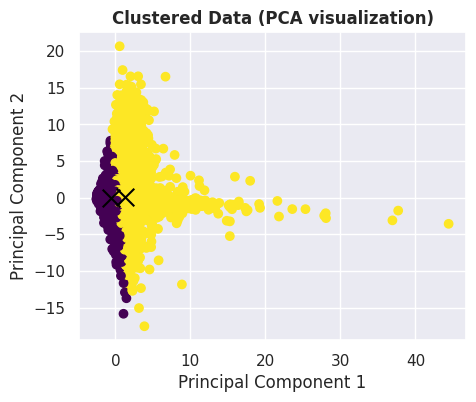

In [23]:
sns.set( rc={'figure.figsize':(5,4)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=160, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# добавить легенду

plt.title('Clustered Data (PCA visualization)',fontweight='bold')

plt.show()

For me it doesn't look believable.. Though, there is no certain borderline to have these two clusters. As for me there is no possible clustering at all. Just one big chunk of data.. Numbers below for inertia and silhouette support this opinion (inertia is enormous and silhouette is not big enough)

In [24]:
print("Inertia score: %0.1f" % kmeans.inertia_,
    "\nSilhouette score: %0.1f" % silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean'))

Inertia score: 272124.6 
Silhouette score: 0.5


### 

In [25]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

I tried to use this algorithm on full dataset but I ended up with some kind of memory error. Therefore, I've decided to run it on a (large) part of dataset

In [26]:
X = data_scaled.drop("Cluster",axis=1)
X = X[:10000]
cluster = AgglomerativeClustering(n_clusters=2)
cluster.fit(X)
X['Cluster'] = cluster.labels_
X['Cluster'].value_counts()



0    8539
1    1461
Name: Cluster, dtype: int64

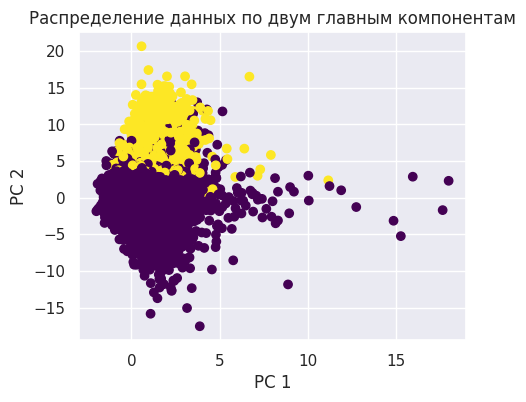

In [27]:
sns.set(rc={'figure.figsize':(5,4)},font_scale=1)

plt.scatter(x=pca_2_result[:10000, 0] , y=pca_2_result[:10000, 1],c=cluster.labels_, cmap = "viridis")
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

Since I reduced the dataset, I cannot actually compare these two clustering algorithms but visually it looks meaningless too.. But still better. Maybe if I were to visualize it not using PCs it would look better

In [28]:
print("Silhouette Coefficient: %0.3f", metrics.silhouette_score(X, cluster.labels_))

Silhouette Coefficient: %0.3f 0.24271024696710847


It looks like this one is a little better than Kmeans according to silhouette. I don't even try to replicate inertia metric because it's meaningless for this algorithm